In [22]:
using Distributions, ForwardDiff

include("src/utils.jl");
include("src/mcmc.jl");
include("src/plotting.jl");

In [15]:
N = 1000;
realmu = 10.0;
realphi = 2.0;
realxi = .3;

m₁ = Float64[];
m₂ = Float64[];
m₃ = Float64[];
s²₁ = Float64[];
s²₂ = Float64[];
s²₃ = Float64[];

MCKL = Float64[];

In [16]:
data = rand(GeneralizedExtremeValue(realmu, exp(realphi), realxi), N);

In [17]:
n_epoch = 10;
epoch_size = 2;

push!(m₁, 0.0);
push!(m₂, 0.0);
push!(m₃, 0.0);
push!(s²₁, 1.0);
push!(s²₂, 1.0);
push!(s²₃, 1.0);

In [18]:
f(θ::DenseVector) = logposterior(θ, data);

for _ = 1:n_epoch
    for _ = 1:epoch_size
        push!(m₁, findMode(θ -> f([θ[1], m₂[end], m₃[end]]), [m₁[end], m₂[end], m₃[end]])[1]);
        push!(m₂, findMode(θ -> f([m₁[end], θ[2], m₃[end]]), [m₁[end], m₂[end], m₃[end]])[2]);
        push!(m₃, findMode(θ -> f([m₁[end], m₂[end], θ[3]]), [m₁[end], m₂[end], m₃[end]])[3]);
    end
    
    push!(s²₁, -1/getSecondDerivative(μ -> f([μ, m₂[end], m₃[end]]), m₁[end]));
    push!(s²₂, -1/getSecondDerivative(ϕ -> f([m₁[end], ϕ, m₃[end]]), m₂[end]));
    push!(s²₃, -1/getSecondDerivative(ξ -> f([m₁[end], m₂[end], ξ]), m₃[end]));
    
    μMarginal = Normal(m₁[end], sqrt(s²₁[end]));
    ϕMarginal = Normal(m₂[end], sqrt(s²₂[end]));
    ξMarginal = Normal(m₃[end], sqrt(s²₃[end]));
    
    approxMarginals = [μMarginal, ϕMarginal, ξMarginal];
    push!(MCKL, MonteCarloKL(f, approxMarginals))
end;

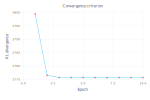

In [23]:
plotConvergenceCriterion(MCKL)

In [24]:
niter = 100000;
δ = [1, .015, .02];
y0 = [0.0, 0.0, 0.0];

θ = mcmc(niter, δ, y0, data);

Taux d'acceptation (%) : [24.507245072450726, 23.217232172321722, 22.42022420224202]


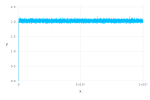

In [26]:
plot(x=1:niter, y=θ[2, :], Geom.line)

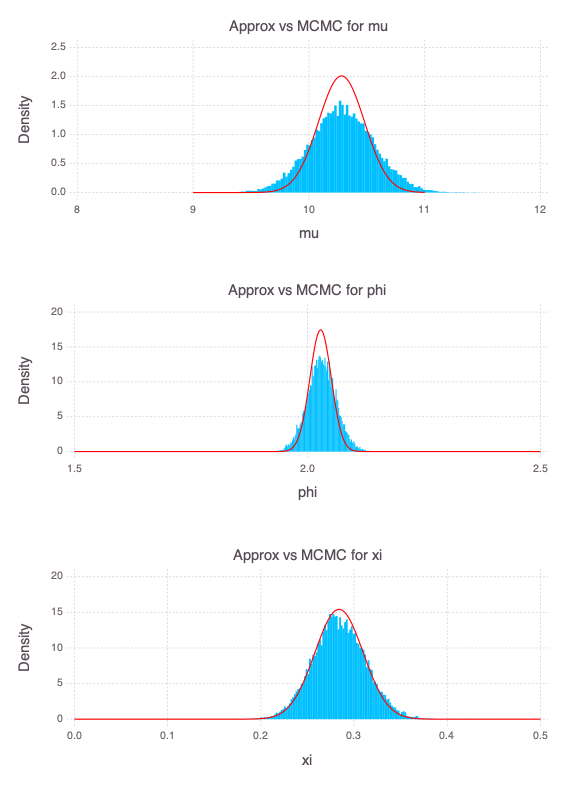

In [27]:
include("src/plotting.jl")

warmingSize = 100;

approxMarginals = [
    Normal(m₁[end], sqrt(s²₁[end])),
    Normal(m₂[end], sqrt(s²₂[end])),
    Normal(m₃[end], sqrt(s²₃[end])),
]

plotApproxVSMCMC(approxMarginals, θ, warmingSize)